In [10]:
import emlddmm
import numpy as np
import torch
import json
import os
import transformation_graph_v01 as tg
import importlib
import pickle

In [2]:
reg_list = [
    {
        'registration': [['CCF','average_template_50'], ['HIST_MD816', 'nissl']],
        'source': '/home/brysongray/data/MD816_mini/average_template_50.vtk',
        'target': '/home/brysongray/data/MD816_mini/MD816_STIF_mini_new',
        'config': '/home/brysongray/emlddmm/examples/configMD816_Nissl_to_CCF.json',
        'output': '/home/brysongray/emlddmm/outputs/outputs_test2/'
    },
    {
        'registration': [['CCF','average_template_50'], ['MRI', 'masked']],
        'source': '/home/brysongray/data/MD816_mini/average_template_50.vtk',
        'target': '/home/brysongray/data/MD816_mini/HR_NIHxCSHL_50um_14T_M1_masked.vtk',
        'config': '/home/brysongray/emlddmm/examples/configMD816_MR_to_CCF.json',
        'output': '/home/brysongray/emlddmm/outputs/outputs_test2/'
    },
    {
        'registration': [['CCF','average_template_50'], ['MRI', 'unmasked']],
        'source': '/home/brysongray/data/MD816_mini/average_template_50.vtk',
        'target': '/home/brysongray/data/MD816_mini/HR_NIHxCSHL_50um_14T_M1.vtk',
        'config': '/home/brysongray/emlddmm/examples/configMD816_MR_to_CCF.json',
        'output': '/home/brysongray/emlddmm/outputs/outputs_test2/'
    }
]

registering /home/brysongray/data/MD816_mini/average_template_50.vtk to /home/brysongray/data/MD816_mini/MD816_STIF_mini_new
loading target images
Found 2 scales


[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())
/home/brysongray/emlddmm/emlddmm.py:98: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Iteration 20, translation oscilating, reducing eA to 90000.0
Iteration 30, linear oscilating, reducing eA to 81000.0
Iteration 40, translation oscilating, reducing eA to 72900.0
Iteration 50, linear oscilating, reducing eA to 65610.0
Iteration 60, translation oscilating, reducing eA to 59049.0
Iteration 70, translation oscilating, reducing eA to 53144.1
Iteration 80, linear oscilating, reducing eA to 47829.69
Iteration 90, linear oscilating, reducing eA to 43046.721000000005
output dir is /home/brysongray/emlddmm/outputs/outputs_test2/
cpu


/home/brysongray/emlddmm/emlddmm.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


registering /home/brysongray/data/MD816_mini/average_template_50.vtk to /home/brysongray/data/MD816_mini/HR_NIHxCSHL_50um_14T_M1_masked.vtk
Found 2 scales
Iteration 30, linear oscilating, reducing eA to 9000.0
Iteration 40, linear oscilating, reducing eA to 8100.0
output dir is /home/brysongray/emlddmm/outputs/outputs_test2/
cpu
registering /home/brysongray/data/MD816_mini/average_template_50.vtk to /home/brysongray/data/MD816_mini/HR_NIHxCSHL_50um_14T_M1.vtk
Found 2 scales
Iteration 20, translation oscilating, reducing eA to 45000.0
Iteration 30, translation oscilating, reducing eA to 40500.0
Iteration 40, translation oscilating, reducing eA to 36450.0
Iteration 50, translation oscilating, reducing eA to 32805.0
Iteration 60, translation oscilating, reducing eA to 29524.5
Iteration 70, translation oscilating, reducing eA to 26572.05
Iteration 80 reducing ev to 0.0009000000000000001
Iteration 80, translation oscilating, reducing eA to 23914.845
Iteration 90 reducing ev to 0.00081000000

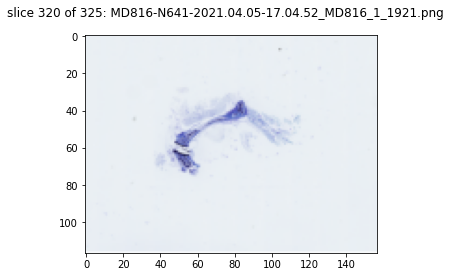

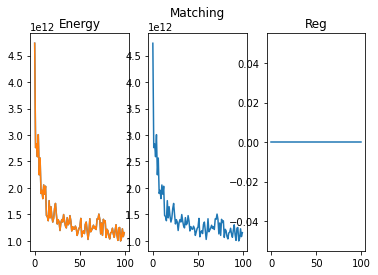

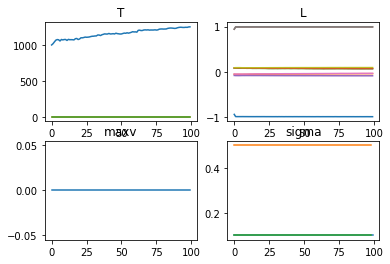

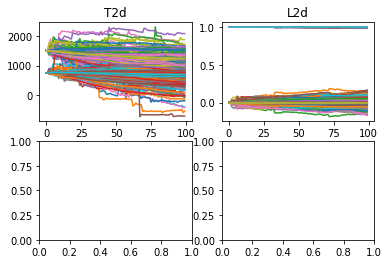

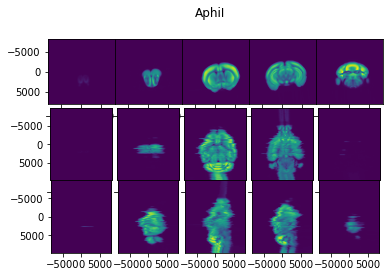

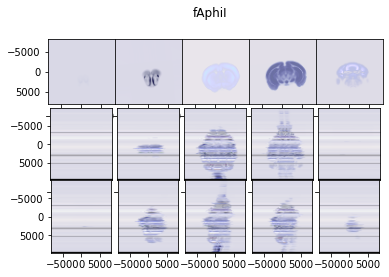

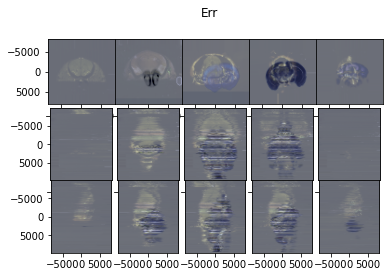

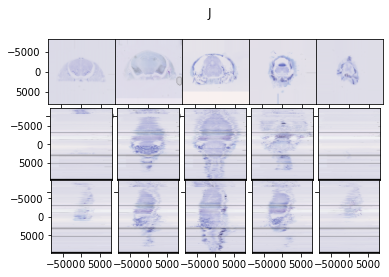

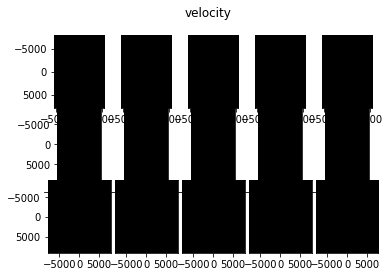

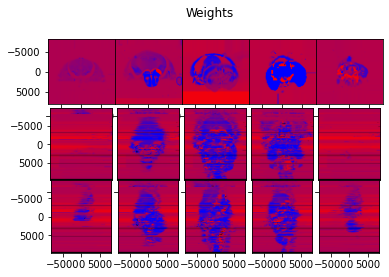

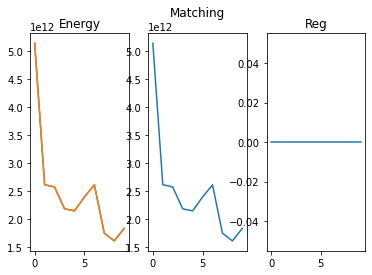

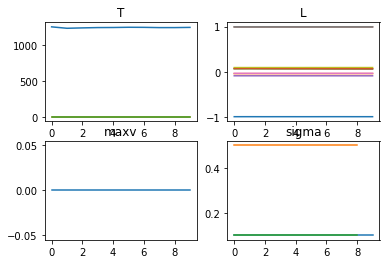

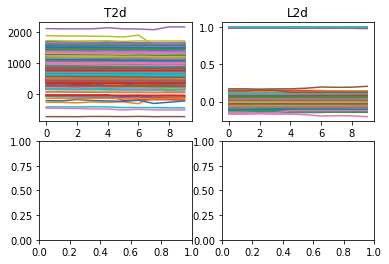

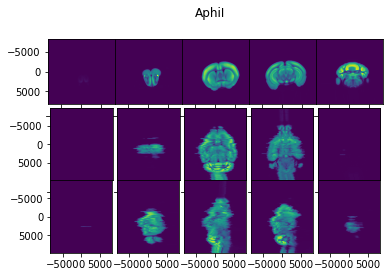

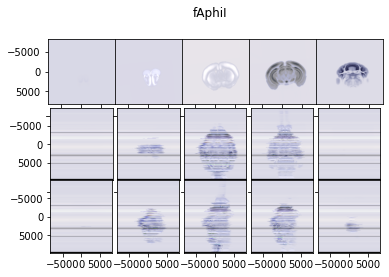

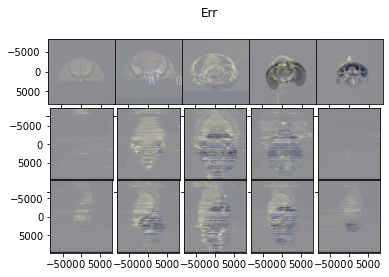

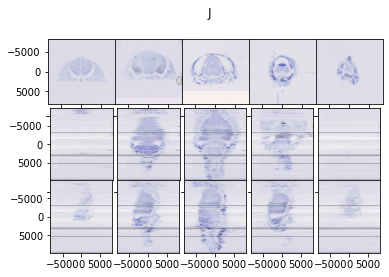

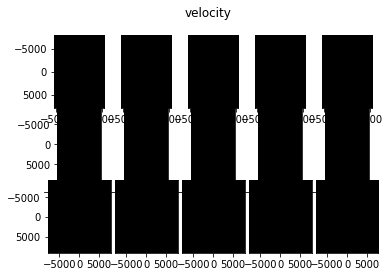

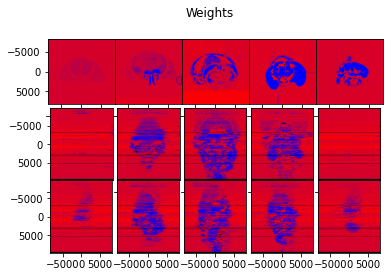

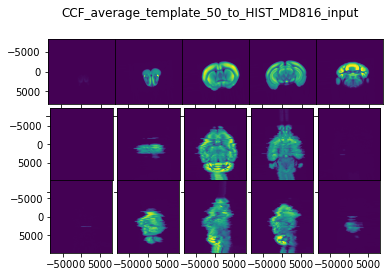

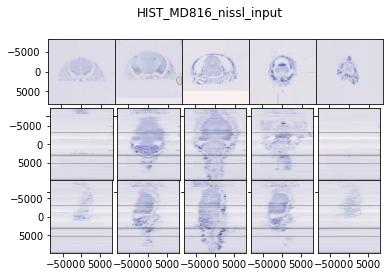

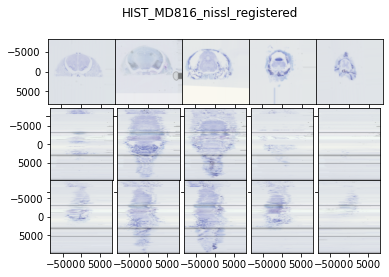

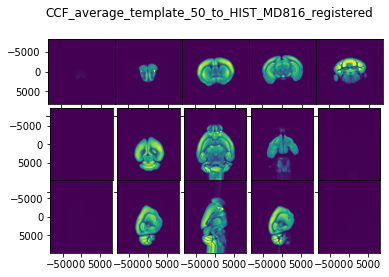

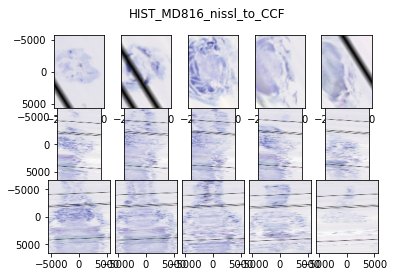

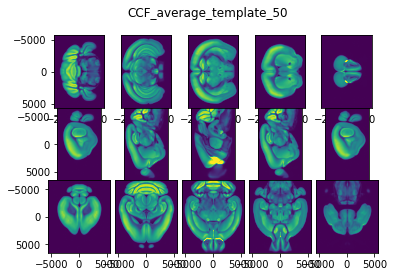

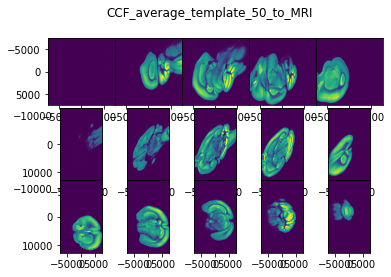

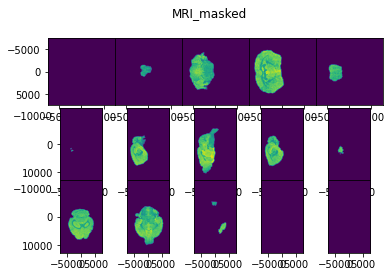

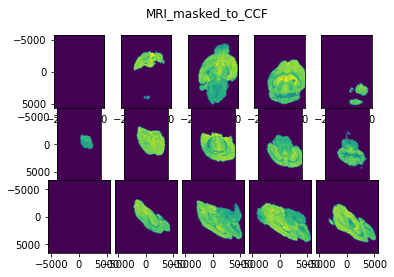

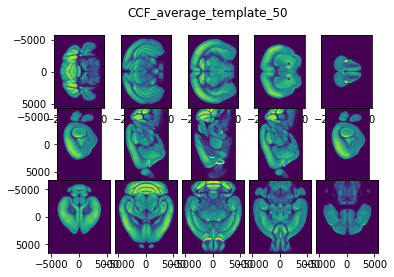

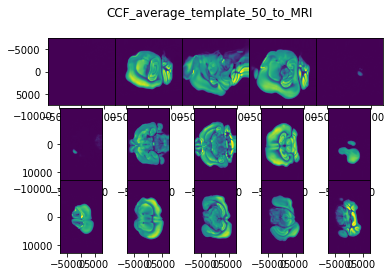

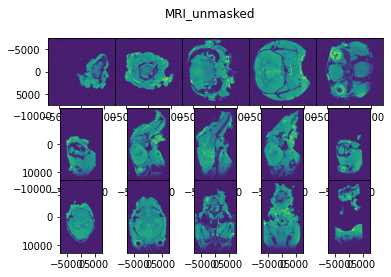

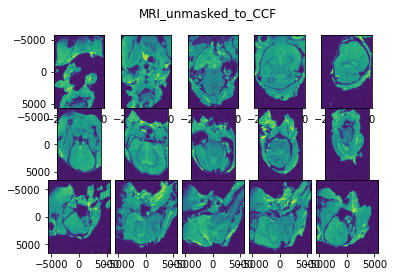

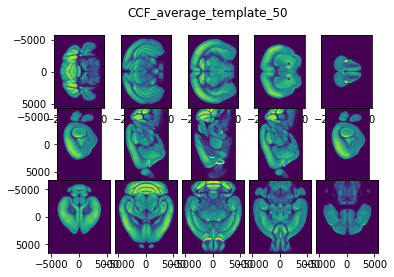

In [3]:
importlib.reload(emlddmm)
importlib.reload(tg)
output = reg_list[0]['output']

graph = tg.run_registrations(reg_list)
with open(os.path.join(output, 'graph.p'), 'wb') as f:
    pickle.dump(graph, f)

In [ ]:
space_image_path = [
    ['CCF','average_template_50', '/home/brysongray/data/MD816_mini/average_template_50.vtk'],
    ['HIST_MD816', 'nissl', '/home/brysongray/data/MD816_mini/MD816_STIF_mini_new'],
    ['MRI', 'masked', '/home/brysongray/data/MD816_mini/HR_NIHxCSHL_50um_14T_M1_masked.vtk'],
    ['MRI', 'unmasked', '/home/brysongray/data/MD816_mini/HR_NIHxCSHL_50um_14T_M1.vtk']
                   ]
# convert space_image_path to dictionary of dictionaries. (image_name:path key-values in a dict of space:img key-values)
sip = {} # space-image-path dictionary
for i in range(len(space_image_path)):
    if not space_image_path[i][0] in sip:
        sip[space_image_path[i][0]] = {}
    new_img = {space_image_path[i][1]: space_image_path[i][2]}
    sip[space_image_path[i][0]].update(new_img)

print(sip)

In [ ]:
importlib.reload(tg)
importlib.reload(emlddmm)

with open(os.path.join(output, 'graph.p'), 'rb') as f:
    graph = pickle.load(f)

# perform all reconstructions
for src_space in sip:
    for src_image in sip[src_space]:
        # reconstruct in every other space
        src_path = sip[src_space][src_image]
        I = emlddmm.Image(src_space, src_image, src_path, x=graph.spaces[src_space][1])
        for target_space in [n for n in sip if n != src_space]:
            target_image = list(sip[target_space].keys())[0]
            target_path = sip[target_space][target_image]
            if os.path.splitext(target_path)[-1] == '':
                fnames = emlddmm.fnames(target_path)
                tg.graph_reconstruct(graph, output, I, target_space, target_fnames=fnames)
            else:
                tg.graph_reconstruct(graph, output, I, target_space)